# Model Evaluation

After the model has been trained, the next step is to evaluate the model on the test set that was splitted using the train test split method. This step is necassary in order to find out how the model will perform with unseen data.

Now, let's import confusion matrix, accuracy score, and ROC AUC score methods for evaluating the models. Also, I will be importing precision score and recall score from sklearn since they are not available in cuML package.

In [167]:
from cuml.metrics import confusion_matrix
from cuml.metrics.accuracy import accuracy_score
from cuml.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Random Forest

I will use the predictions of the first experiment, since it was the best with standard set of parameters.

In [175]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test.values_host, y_pred.values_host))
print('Recall score: ', recall_score(y_test.values_host, y_pred.values_host))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred))

Accuracy score:  0.7332103252410889
Precision score:  0.7408040170896073
Recall score:  0.7636807704416948
ROC AUC score:  0.7312757968902588


In [176]:
confusion_matrix(y_test.astype('int32'), y_pred.astype('int32'))

array([[722863, 311467],
       [275470, 890199]])

It can be seen from the confusion matrix that the number of false positives and false negatives are more. The accuracy and ROC AUC are both approximately 73%, precision is 74%, while recall score is 76%. As, it is evident because of the high volume of data, more predictions are required leading to high recall score.

## XGBoost

The first experiment predictions will be taken for consideration because it was better.

In [177]:
print('Accuracy score: ', accuracy_score(y_test, bst_predictions))
print('Precision score: ', precision_score(y_test.values_host, bst_predictions))
print('Recall score: ', recall_score(y_test.values_host, bst_predictions))
print('ROC AUC score: ', roc_auc_score(y_test, bst_pred))

Accuracy score:  0.742078959941864
Precision score:  0.7518457679733472
Recall score:  0.7660665248882831
ROC AUC score:  0.8233452439308167


In [178]:
confusion_matrix(y_test.astype('int32'), bst_predictions.astype('int32'))

array([[739593, 294737],
       [272689, 892980]])

In XGBoost, the false positive is slightly less than Random forest whereas others are almost are same. Here also, the recall is more but there is not much difference between precision and recall. The accuracy and ROC AUC scores are also better than Random Forest. 

## Benchmark CPU and GPU performance

In this section I will compare the performance of both the models in CPU and GPU. Let's import some important packages

In [55]:
from timeit import default_timer
from cudf import Series
import cupy
from scipy.sparse import csr_matrix
from cuml import RandomForestClassifier as cu_rf
from sklearn.ensemble import RandomForestClassifier as skl_rf
from sklearn.metrics import accuracy_score as skl_acc

### Random Forest

This function take in the classifiers and the datasets and will return the training time, prediction time, number of training vectors and accuracy score. The below functions have been taken from the lab materials and have been modified to use with Random Forest.

In [56]:
def time_rf(clf, X_train, X_test, y_train, y_test):
    """ Helper script to measue time to fit and predict a classifier .
    
    Parameters:
    clf - initialized classifier
    X_train - feature vectors for training
    X_test - feature vectors for testing
    y_train - train labels
    y_test - test labels
    
    Retruns a list of four values [m, t_fit, t_pred, acc]:
    m - number of training vectors
    t_fit - time to train in seconds
    t_pred - time to predict in seconds
    acc - accuracy score
    """
    
    # Measure time to fit
    start = default_timer()
    clf.fit(X_train, y_train)
    stop = default_timer()
    t_fit = stop - start
    
    # Measure time to predict
    start = default_timer()
    clf.predict(X_train)
    stop = default_timer()
    t_pred = stop - start
        
    # Calculate accuracy
    y_pred = clf.predict(X_test)
    if isinstance(y_pred, Series):
        # calculate accuracy with cuml
        acc = cuml.metrics.accuracy_score(y_test, y_pred)
    else: 
        # calculate accuracy with sklearn
        acc = skl_acc(y_test, y_pred)
        
    return [X_train.shape[0], t_fit, t_pred, acc]

The below functions intialise the classifiers and send the data to time_rf function. The sklearn training will only be performed till 50000 samples, because it takes time to train on CPU. This is enough to give us the difference in training times between cuML on GPU and sklearn on CPU. Also, the cuDF dataframes are converted to numpy array before passing it to sklearn for training. 

In [57]:
def cuml_time_rf(X_train, X_test, y_train, y_test, params):
    # initalise cuml random forest classifier
    clf = cu_rf(**params)
    return time_rf(clf, X_train, X_test, y_train, y_test)    

def skl_time_rf(X_train, X_test, y_train, y_test, params):
    if X_train.shape[0] <= 50000: # cut-off for Sklearn training
        clf = skl_rf(**params)
        # convert cuDF dataframes to numpy array
        X_train = cupy.asnumpy(X_train.values_host)
        X_test = cupy.asnumpy(X_test.values_host)
        y_train = cupy.asnumpy(y_train)
        y_test = cupy.asnumpy(y_test)
        return time_rf(clf, X_train, X_test, y_train, y_test)
    else:
        return [X_train.shape[0], np.nan, np.nan, np.nan]

This run_benchmark function will train the models with batches of data so that we see the results as we move ahead in training. It returns the results in matrices with four columns: number of vectors, time to fit, time to predict, and accuracy score.

In [58]:
def run_benchmark(X_train, X_test, y_train, y_test, m_list, params, run_skl=True, run_cuml=True):
    # We store the benchmark results in matrices with four columns: m, t_fit, t_pred, accuracy
    res_skl = np.zeros((len(m_list),4)) 
    res_cuml = np.zeros((len(m_list),4)) 
        
    i = 0
    for m in m_list:
        X_in = X_train.iloc[:m,:]
        y_in = y_train[:m]

        if run_cuml:            
            res_cuml[i,:] = cuml_time_rf(X_in, X_test, y_in, y_test, params)
            print('cuML    time for traning size {:6} is {:4.2f} sec, accuracy {:%}'.format(m, res_cuml[i,1], res_cuml[i,3]))
            
        if run_skl:
            res_skl[i,:] = skl_time_rf(X_in, X_test, y_in, y_test, params)
            print('Skl     time for traning size {:6} is {:4.2f} sec, accuracy {:%}'.format(m, res_skl[i,1], res_skl[i,3]))      
        i += 1      

    return res_cuml, res_skl

The parameters are kept at a moderate value, so that even sklearn can handle it, because the dataset is huge.

In [59]:
params = {
    'n_estimators': 100, # Number of trees in RF
    'max_depth': 10, # max depth of each tree
    'random_state': 321
}

In [60]:
# We start with a warmup
_ = run_benchmark(X_train_scaled, X_test_scaled, y_train, y_test, [10, 100], params)

# Run the benchmark
m_list = [10, 100, 1000, 10000, 50000, 100000, 200000, 300000, 400000, X_train.shape[0]]
res_cuml, res_skl = run_benchmark(X_train_scaled, X_test_scaled, y_train, y_test, m_list, params)

cuML    time for traning size     10 is 0.06 sec, accuracy 53.225207%
Skl     time for traning size     10 is 0.08 sec, accuracy 50.764432%
cuML    time for traning size    100 is 0.12 sec, accuracy 58.024752%
Skl     time for traning size    100 is 0.09 sec, accuracy 58.928572%
cuML    time for traning size     10 is 0.04 sec, accuracy 53.225207%
Skl     time for traning size     10 is 0.09 sec, accuracy 50.764432%
cuML    time for traning size    100 is 0.12 sec, accuracy 58.024752%
Skl     time for traning size    100 is 0.10 sec, accuracy 58.928572%
cuML    time for traning size   1000 is 0.16 sec, accuracy 66.361892%
Skl     time for traning size   1000 is 0.26 sec, accuracy 66.413985%
cuML    time for traning size  10000 is 0.17 sec, accuracy 69.957441%
Skl     time for traning size  10000 is 2.36 sec, accuracy 70.011214%
cuML    time for traning size  50000 is 0.25 sec, accuracy 70.828623%
Skl     time for traning size  50000 is 12.31 sec, accuracy 70.851169%
cuML    time for tr

The trainig times can be seen here. The cuML is performing a lot better when the size of the dataset increases. There is not much difference in accuracy though. The results of the benchmark are plotted below.

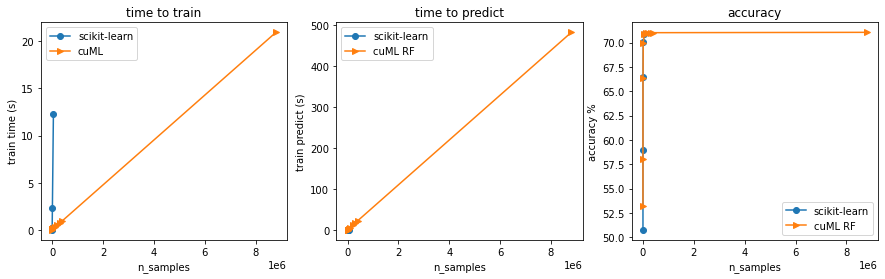

In [61]:
fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(131)
ax.plot(res_skl[:,0], res_skl[:,1], 'o-', label='scikit-learn')

ax.plot(res_cuml[:,0], res_cuml[:,1], '>-', label='cuML')
   
ax.set_xlabel('n_samples')
ax.set_ylabel('train time (s)')
ax.legend()
ax.set_title('time to train')

ax = fig.add_subplot(132)
ax.plot(res_skl[:,0], res_skl[:,2], 'o-', label='scikit-learn')
ax.plot(res_cuml[:,0], res_cuml[:,2], '>-', label='cuML RF')
ax.set_xlabel('n_samples')
ax.set_ylabel('train predict (s)')
ax.legend()
ax.set_title('time to predict')

ax = fig.add_subplot(133)
ax.plot(res_skl[:,0], res_skl[:,3]*100, 'o-', label='scikit-learn')
ax.plot(res_cuml[:,0], res_cuml[:,3]*100, '>-', label='cuML RF')
ax.set_xlabel('n_samples')
ax.set_ylabel('accuracy %')
ax.legend()
ax.set_title('accuracy')
plt.show()

It can be seen that the training on CPU with sklearn was taking too much time whereas the cuML was training faster. The accuracy is almost same between the two. There is less observation for sklearn here because we took less samples. But the results gives clear indications that cuML was faster than sklearn.

### XGBoost

Let's compare the CPU and GPU training times for XGBoost algorithm.

In [62]:
import xgboost as xgb

In [63]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dvalidation = xgb.DMatrix(X_test_scaled, label=y_test)

The XGBoost package gives functionality to train on both CPU and GPU. There only has to be some changes in parameters. The 'tree_method' should change to hist and n_gpus should be changed to 0 to train on CPU. Below I will set the separate parameters variable for both CPU and GPU.

In [64]:
# parameters for GPU
params_gpu = {
    'silent': 1, 'tree_method': 'gpu_hist', 'n_gpus': 1, 'eval_metric': 'auc', 
    'objective': 'binary:logistic',
}

# parameters for CPU 
params_cpu = {
    'silent': 1, 'tree_method': 'hist', 'n_gpus': 0, 'eval_metric': 'auc', 
    'objective': 'binary:logistic',
}

100 steps are enough to give us the clear undertanding of the difference.

In [65]:
# model training settings
evallist = [(dvalidation, 'validation'), (dtrain, 'train')]
num_round = 100

In [76]:
%%time

bst_gpu = xgb.train(params_gpu, dtrain, num_round, evallist)

[16:05:59] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:576: 
Parameters: { "n_gpus", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74346	train-auc:0.74303
[1]	validation-auc:0.75482	train-auc:0.75451
[2]	validation-auc:0.76458	train-auc:0.76433
[3]	validation-auc:0.77001	train-auc:0.76988
[4]	validation-auc:0.77490	train-auc:0.77481
[5]	validation-auc:0.78058	train-auc:0.78058
[6]	validation-auc:0.78486	train-auc:0.78496
[7]	validation-auc:0.78731	train-auc:0.78747
[8]	validation-auc:0.78977	train-auc:0.78991
[9]	validation-auc:0.79189	train-auc:0.79205
[10]	validation-auc:0.79357	train-auc:0.79377
[11]	validation-auc:0.79512	train-auc:0.79533
[12]	validation-auc:0.79724	train-

The time taken for GPU training is 3.33 seconds

In [77]:
%%time

bst_cpu = xgb.train(params_cpu, dtrain, num_round, evallist)

[16:07:10] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:576: 
Parameters: { "n_gpus", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74347	train-auc:0.74307
[1]	validation-auc:0.75501	train-auc:0.75472
[2]	validation-auc:0.76469	train-auc:0.76448
[3]	validation-auc:0.77010	train-auc:0.76999
[4]	validation-auc:0.77504	train-auc:0.77492
[5]	validation-auc:0.78095	train-auc:0.78071
[6]	validation-auc:0.78529	train-auc:0.78475
[7]	validation-auc:0.78807	train-auc:0.78664
[8]	validation-auc:0.79066	train-auc:0.78761
[9]	validation-auc:0.79304	train-auc:0.78750
[10]	validation-auc:0.79516	train-auc:0.78781
[11]	validation-auc:0.79665	train-auc:0.78608
[12]	validation-auc:0.79803	train-

The time taken for CPU training is 26 seconds, there is a big difference. 

## Conclusion

I have trained Random Forest and XGBoost algorithms with RAPIDS frameworks on GPU. Both the models performs well with not much difference in their evaluation scores. The accuracy score of Random Forest is 73% while XGBoost is 74%. I tried some hyperparameters optimisations for both the models but there was not much changes in their accuracies. The PCA transormations for both the models didn't perform well. The accuracy and performance mostly depends on the quality of data. Higgs boson particle detection is a difficult problem. It is a very rare particle and hard to detect. Lot of feature engineering is required to improve the quality of the data. For this reason, neural netwroks can be useful for extracting the features automatically. In the end, I performed benchmark between GPU and CPU by training the models on GPU and CPU. And obviously there was a huge difference in training times as GPU trains a lot faster than CPU.